<a href="https://colab.research.google.com/github/mascneto/Musical-Genres/blob/master/generos_musicais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# No início do seu trabalho
import os
os.environ['KAGGLE_USERNAME'] = 'josmascarenhaslneto'

# Faz seu trabalho com Kaggle aqui
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
# api.authenticate()

In [ ]:
api.dataset_download_files('andradaolteanu/gtzan-dataset-music-genre-classification',
                         path='/content',  # Este é o diretório padrão do Colab
                         unzip=True)

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification


In [ ]:
!ls /content/Data/genres_original/

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [ ]:
import os
import shutil # para copiar os arquivos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

base_path = "/content/Data/genres_original"
output_dir = "selected_files"
os.makedirs(output_dir, exist_ok=True)
all_wav_files = []

for genre in os.listdir(base_path):
  genre_path = os.path.join(base_path, genre)
  # print(genre_path)

  if os.path.isdir(genre_path): # Verificar se é um diretório
    wav_files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith(".wav")] # Filtrar apenas arquivos .wav
    wav_files.sort()
    all_wav_files.append(wav_files)


# Converter para uma matriz numpy
wav_matrix = np.array(all_wav_files, dtype=object)

In [ ]:
wav_matrix.shape

(10, 100)

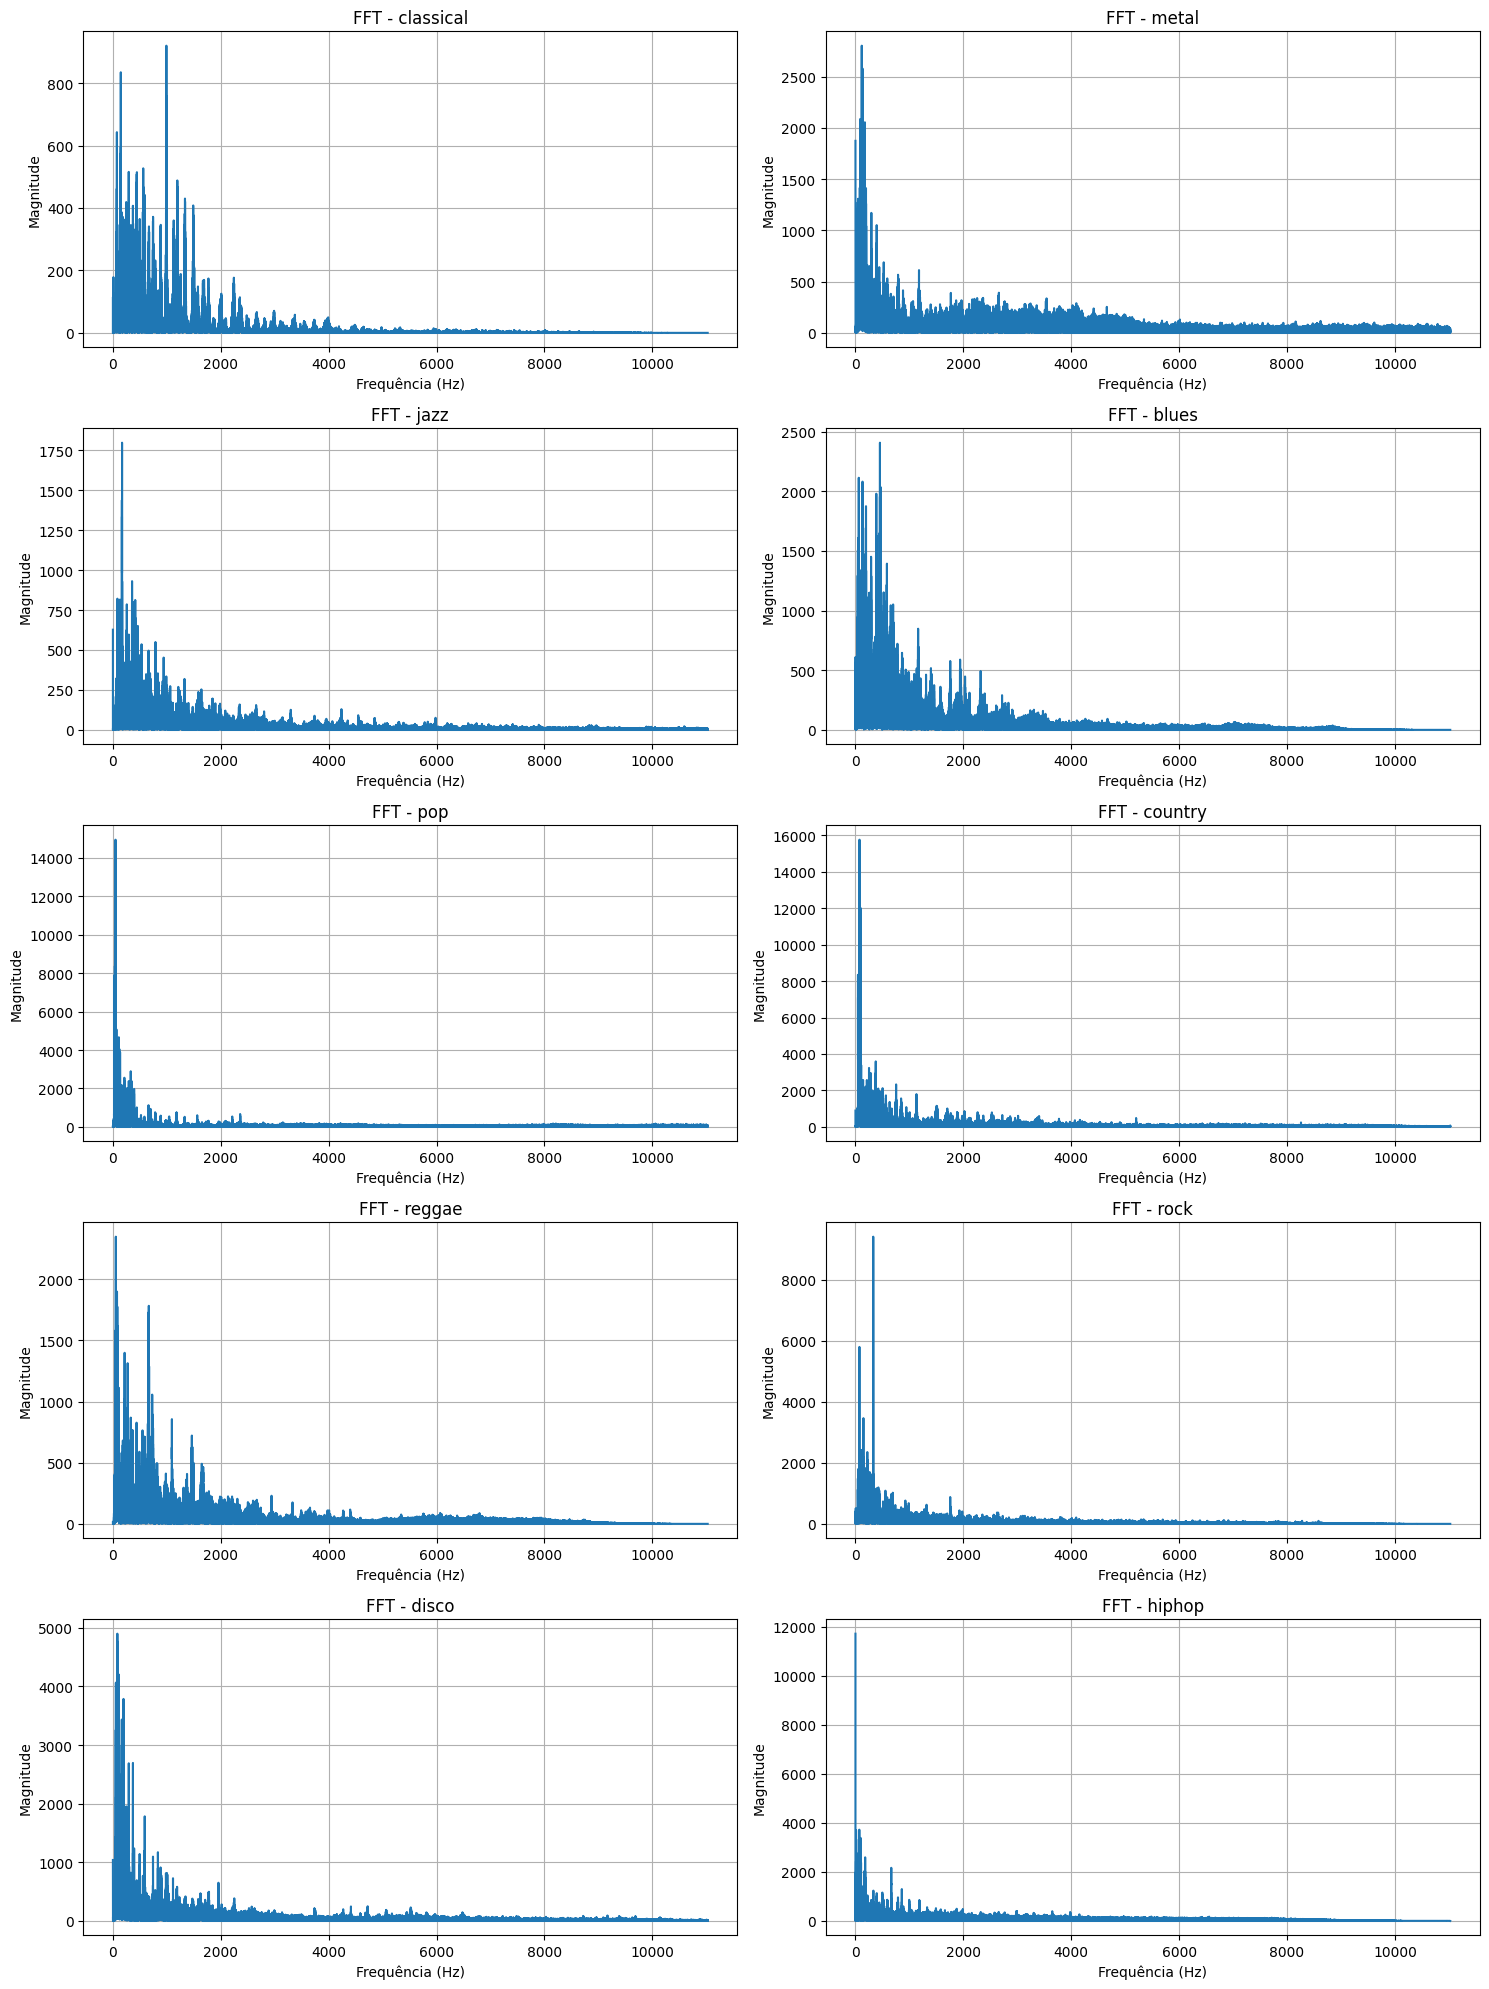

In [ ]:
# Configuração do layout para os gráficos
num_files = len(wav_matrix[:,0])
cols = 2
rows = (num_files + 1) // cols

# Criar a figura para os subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 20))
axs = axs.ravel()  # Para acessar os subplots de forma linear

# Processar cada arquivo e plotar a FFT
for i, file_path in enumerate(wav_matrix[:,0]):
    try:
        # Obter o gênero a partir do caminho do arquivo
        genre = file_path.split('/')[-2]

        # Carregar o áudio
        y, sr = librosa.load(file_path, sr=None)

        # Calcular FFT
        fft = np.fft.fft(y)
        magnitude = np.abs(fft)
        frequency = np.fft.fftfreq(len(magnitude), 1 / sr)

        # Filtrar apenas frequências positivas
        pos_freqs = frequency[:len(frequency) // 2]
        pos_magnitude = magnitude[:len(magnitude) // 2]

        # Plotar a FFT
        axs[i].plot(pos_freqs, pos_magnitude)
        axs[i].set_title(f'FFT - {genre}')
        axs[i].set_xlabel('Frequência (Hz)')
        axs[i].set_ylabel('Magnitude')
        axs[i].grid()

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        axs[i].set_title(f'Erro - {genre}')
        axs[i].axis('off')  # Desativa o subplot em caso de erro

# Ajustar espaçamento entre subplots
plt.tight_layout()
#plt.show()

Sinais reais têm simetria conjugada, ou seja, as frequências negativas são um espelho das frequências positivas. Assim, não há perca de informação ao desconsiderá-las, tornando a análise mais simples.
Matematicamente falando, seja $X[k]$ o resultado da FFT. \\
Então $$X[-k] = \overline{X[k]}$$


In [ ]:
regex = r"genres_original/([^/]+)/"
import re
# Aplicando a regex em cada elemento da matriz, convertendo para string
labels = [re.search(regex, str(path)).group(1) for path in wav_matrix] # Convert path to string using str(path)
labels = np.array(labels)
labels

array(['classical', 'metal', 'jazz', 'blues', 'pop', 'country', 'reggae',
       'rock', 'disco', 'hiphop'], dtype='<U9')

In [ ]:
fft_size = 000
fft_list = [] # armazenar dados da fft para cada arquivo de audio
labels = [] # genre labels para cada arq de audio

for genre_files in wav_matrix:
  for file_path in genre_files:
    try:
      y, sr = librosa.load(file_path, sr=None)
      fft = np.fft.fft(y)
      magnitude = np.abs(fft[:len(fft)//2])

      if len(magnitude) > fft_size:
        magnitude = magnitude[:fft_size]
      else:
        magnitude = np.pad(magnitude, (0, fft_size - len(magnitude)), mode='constant')

      fft_list.append(magnitude)
      labels.append(file_path.split('/')[-2])

    except Exception as e:
      print(f"Erro ao processar {file_path}: {e}")
      continue

fft_array = np.array(fft_list)
fft_array.shape

<ipython-input-56-8d0db6d2fea9>:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erro ao processar /content/Data/genres_original/jazz/jazz.00054.wav: 


(999, 8000)

* Gêneros como metal e rock tem maior amplitude em frequências médias e alta;
* Jazz e classical se concentram em frequências mais baixas.



In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

In [ ]:
from collections import Counter

class_counts = Counter(labels_encoded)
for label, count in class_counts.items():
    print(f"Classe {label}: {count} amostras")


Classe 1: 100 amostras
Classe 6: 100 amostras
Classe 5: 99 amostras
Classe 0: 100 amostras
Classe 7: 100 amostras
Classe 2: 100 amostras
Classe 8: 100 amostras
Classe 9: 100 amostras
Classe 3: 100 amostras
Classe 4: 100 amostras


In [ ]:
unique, counts = np.unique(labels_encoded, return_counts=True)
print(dict(zip(unique, counts)))

{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 99, 6: 100, 7: 100, 8: 100, 9: 100}


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
fft_scaled = scaler.fit_transform(fft_array)

In [ ]:
variances = np.var(fft_scaled, axis=0)
print(f"Variância média: {np.mean(variances)}")

Variância média: 1.0


In [ ]:
from sklearn.model_selection import train_test_split

X = fft_scaled
y = labels_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val,  y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [ ]:
print(f"Tamanho do treino: {len(X_train)}")
print(f"Tamanho da validação: {len(X_val)}")
print(f"Tamanho do teste: {len(X_test)}")

Tamanho do treino: 721
Tamanho da validação: 128
Tamanho do teste: 150


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)

# Agora, transformamos o conjunto de validação (e teste) com o PCA ajustado
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Verificação do resultado
print("Dimensão dos dados transformados:", X_train_pca.shape)

Dimensão dos dados transformados: (721, 379)


In [ ]:
print("Variância explicada por componente:", pca.explained_variance_ratio_)
print("Variância total explicada:", pca.explained_variance_ratio_.sum())

Variância explicada por componente: [0.21066481 0.05081844 0.03098635 0.02184309 0.01769686 0.01684293
 0.01492721 0.012085   0.01144552 0.01087511 0.00999749 0.00881608
 0.00820985 0.00808619 0.0078006  0.00730306 0.00721631 0.00673539
 0.00658823 0.00631527 0.0060836  0.00600307 0.00582214 0.00564707
 0.00543837 0.00499755 0.00487117 0.004698   0.00454599 0.0044367
 0.00432272 0.00421822 0.00406705 0.00399576 0.00391276 0.00388538
 0.00373887 0.00367329 0.00358394 0.00350049 0.00343719 0.00334371
 0.00328289 0.00319395 0.00315137 0.00312008 0.00308449 0.0030358
 0.00300017 0.00295208 0.00288483 0.00287514 0.00283698 0.00278751
 0.00275149 0.00274598 0.00272096 0.00268005 0.00266102 0.00263205
 0.00258585 0.00256418 0.00253984 0.0025304  0.00250732 0.00248924
 0.00245579 0.00244514 0.002419   0.00239221 0.00236178 0.00233789
 0.00229807 0.00228735 0.00228035 0.0022429  0.0022194  0.00220441
 0.00220169 0.00217573 0.00213526 0.0021205  0.0021157  0.00209153
 0.00207137 0.00206561 0.002

Após a redução para 3 componentes principais, menos de 30% da informação original dos dados foi mantida.

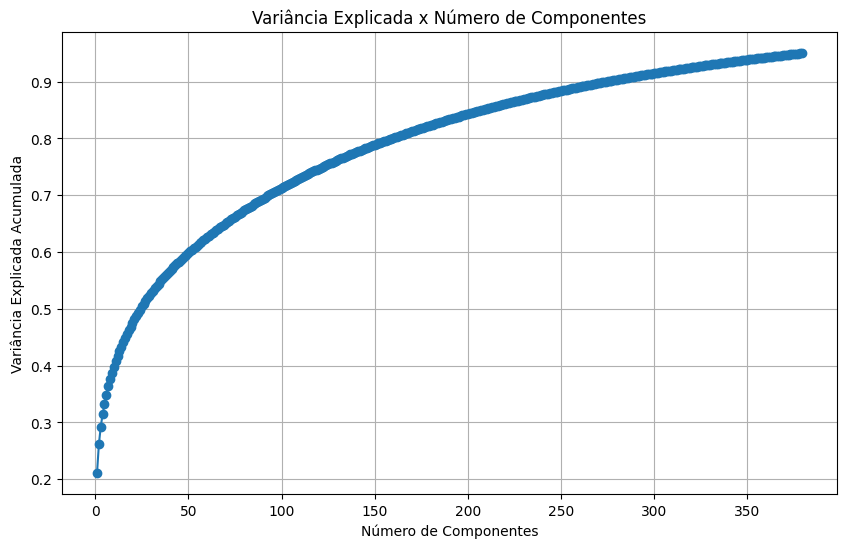

In [ ]:
### Variância explicada acumulada em função do número de componentes
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada x Número de Componentes')
plt.grid()
plt.show()

<ipython-input-70-12829596d160>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], cmap='viridis', alpha=0.5)


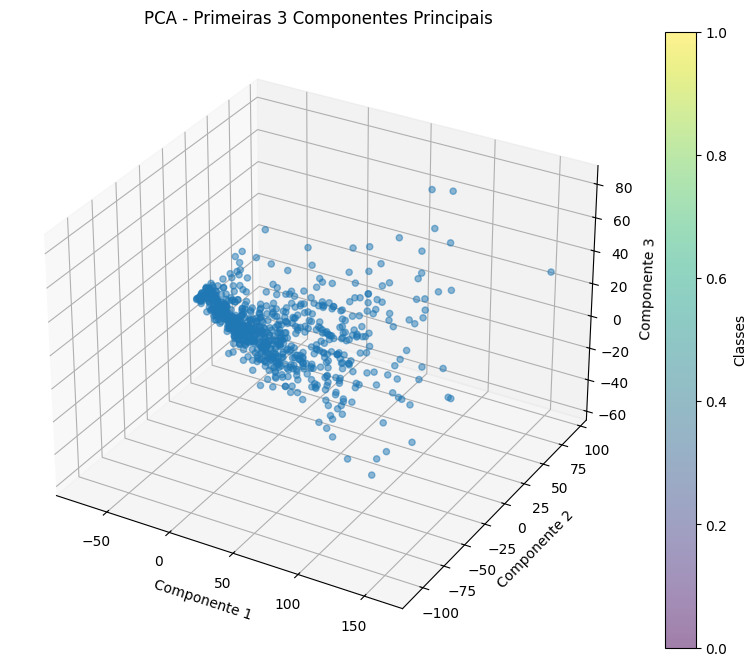

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Gráfico 3D das primeiras 3 componentes principais
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], cmap='viridis', alpha=0.5)
ax.set_title('PCA - Primeiras 3 Componentes Principais')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
fig.colorbar(scatter, label='Classes')
plt.show()


In [ ]:
from sklearn.svm import SVC

# Instanciar o modelo SVM
svm_clf = SVC(kernel='rbf', random_state=42)

# Treinar o SVM
svm_clf.fit(X_train_pca, y_train)

SVC(random_state=42)

In [ ]:
# Validação
X_val_pca  = pca.transform(X_val)
y_val_pred = svm_clf.predict(X_val_pca)

In [ ]:
# Avaliar o modelo no conjunto de validação
from sklearn.metrics import classification_report, accuracy_score

print("Acurácia no conjunto de validação:", accuracy_score(y_val, y_val_pred))
print("Relatório de Classificação no conjunto de validação:")
print(classification_report(y_val, y_val_pred))

Acurácia no conjunto de validação: 0.2421875
Relatório de Classificação no conjunto de validação:
              precision    recall  f1-score   support

           0       1.00      0.17      0.29        18
           1       0.31      0.71      0.43        14
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        12
           4       0.35      0.47      0.40        17
           5       0.12      0.08      0.10        12
           6       0.00      0.00      0.00        12
           7       0.33      0.15      0.21        13
           8       0.06      0.10      0.07        10
           9       0.24      0.67      0.35         9

    accuracy                           0.24       128
   macro avg       0.24      0.24      0.19       128
weighted avg       0.29      0.24      0.20       128



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.model_selection import GridSearchCV

# Definição da grade de parâmetros para o GridSearch
param_grid = {
    'C': [0.1, 1, 10, 100], # Parâmetros de regularização
    'gamma' : [0.001, 0.01, 0.1, 1], # Parâmetro de escala do kernel
    'kernel': ['rbf', 'linear', 'poly'] # Tipos de kernel
}

"""
C: controla a penalidade para erros de classificação.
Valores mais altos de C tentam reduzir os erros, mas podem levar a overffiting

gamma: Controla o quanto a influênca de um único ponto de treino se estende.
Valores mais baixos significam maior alcance

kernel: define o tipo de kernel a ser usado.
"""
svm_clf = SVC(random_state=42) # Instaciar o modelo SVM

# Configurar o GridSearchCV
grid_search = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid,
    cv=5, # qtd de folds na validação cruzada
    n_jobs=-1, # Todos os núcleos do processador p/ acelerar a busca
    verbose=5 # Exibe o progresso durante a execução
)

In [ ]:
grid_search.fit(X_train_pca, y_train)
grid_search.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}

In [ ]:
best_model = grid_search.best_estimator_ # melhor modelo encontrado pelo GridSearch

y_val_pred = best_model.predict(X_val_pca)

print("Acurácia no conjunto de validação:", accuracy_score(y_val, y_val_pred))
print("Relatório de Classificação no conjunto de validação:")
print(classification_report(y_val, y_val_pred))

Acurácia no conjunto de validação: 0.515625
Relatório de Classificação no conjunto de validação:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60        18
           1       0.92      0.79      0.85        14
           2       0.30      0.27      0.29        11
           3       0.11      0.08      0.10        12
           4       0.56      0.53      0.55        17
           5       0.80      0.67      0.73        12
           6       0.32      0.50      0.39        12
           7       0.43      0.46      0.44        13
           8       0.70      0.70      0.70        10
           9       0.50      0.33      0.40         9

    accuracy                           0.52       128
   macro avg       0.52      0.50      0.50       128
weighted avg       0.53      0.52      0.52       128



In [ ]:
# No final do trabalho
del os.environ['KAGGLE_USERNAME']
del os.environ['KAGGLE_KEY']